# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1) В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета. \
2) Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение. \
3) Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [114]:
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import shapiro 
from scipy.stats import chi2_contingency, chi2 
import statsmodels.formula.api as smf 

import numpy as np

## Задание 1
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Сначала посмотрим, что из себя представляют данные. Для каждого шага будем выводить промежуточный результат. Данные о времени регистрации:

In [115]:
reg = pd.read_csv('..//shared/problem1-reg_data.csv', sep = ';')
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [116]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Пустых значений нет.

Данные о времени захода пользователей в игру:

In [117]:
auth = pd.read_csv('..//shared/problem1-auth_data.csv', sep = ';')
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [118]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [119]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

Пустых значений нет.

Стобец 'uid' - индификатор пользователя, стобцы 'reg_ts' и 'auth_ts' отображают время регистрации и время захода пользователя в игру. \
Для упрощения работы с данными и тестирования функции возьмем часть данных, состоящую из последних 1000 строк:

In [120]:
reg_test = reg.tail(10000)

In [121]:
auth_test = auth.tail(10000)

Объединим две таблицы по номеру аккаунта: 

In [122]:
reg_auth_test = reg_test.merge(auth_test, how = 'left', on ='uid')
reg_auth_test.head()

,reg_ts,uid,auth_ts
0,1600346220,1099509,NaN
1,1600346273,1099510,NaN
2,1600346326,1099511,NaN
3,1600346379,1099512,NaN
4,1600346432,1099513,NaN


Найдем разность между временем захода в игру и временем регистрации. Для начала, где есть дата регистрации, но нет даты входа, запишем в дату входа дату регистрации. Даты записаны в виде Unix-времени (секунды, прошедшие с начала "эпохи Unix", то есть с полуночи 1 января 1970 года по UTC), поэтому вычитаем из времени захода в игру время регистрации и делим на 24 часа * 60 минут * 60 секунд, округляя до целого. Чтобы первый день захода в игру не отображался в таблице нулем, прибавляем единицу.

In [123]:
reg_auth_test['auth_ts'] = reg_auth_test['auth_ts'].fillna(value=reg_auth_test['reg_ts']).astype(int)
reg_auth_test['diff'] = (reg_auth_test['auth_ts'] - reg_auth_test['reg_ts']) // (24*60*60) + 1
reg_auth_test.head()

,reg_ts,uid,auth_ts,diff
0,1600346220,1099509,1600346220,1
1,1600346273,1099510,1600346273,1
2,1600346326,1099511,1600346326,1
3,1600346379,1099512,1600346379,1
4,1600346432,1099513,1600346432,1


Дату регистрации для удобства переведем в привычный нам формат. Убираем все лишнее, оставляем только год-месяц-день.

In [124]:
reg_auth_test['reg_ts'] = pd.to_datetime(reg_auth_test['reg_ts'], unit='s')
reg_auth_test['reg_ts'] = reg_auth_test['reg_ts'].apply(lambda x: x.strftime('%Y-%m-%d')) # не самое оптимальное решение
reg_auth_test.head()

,reg_ts,uid,auth_ts,diff
0,2020-09-17,1099509,1600346220,1
1,2020-09-17,1099510,1600346273,1
2,2020-09-17,1099511,1600346326,1
3,2020-09-17,1099512,1600346379,1
4,2020-09-17,1099513,1600346432,1


С помощью группировки найдем количество пользователей, который были зарегестрированы в определенный день и зашли в игру через определенное количество дней.

In [125]:
count_uid = reg_auth_test.groupby(['reg_ts', 'diff'], as_index = False).agg({'uid':'nunique'})
count_uid.head()

,reg_ts,diff,uid
0,2020-09-17,1,743
1,2020-09-17,6,30
2,2020-09-18,1,1569
3,2020-09-18,5,41
4,2020-09-18,6,20


Приведем таблицу выше к удобному виду, где название колонок - день регистрации, название столбцов - количество дней с момента регистрации.

In [126]:
count_uid_for_days = pd.pivot(count_uid, index = 'reg_ts', columns = 'diff', values = 'uid')
count_uid_for_days = count_uid_for_days.fillna(0)
count_uid_for_days

diff,1,2,3,4,5,6
reg_ts,,,,,,
2020-09-17,743.0,0.0,0.0,0.0,0.0,30.0
2020-09-18,1569.0,0.0,0.0,0.0,41.0,20.0
2020-09-19,1574.0,0.0,0.0,39.0,21.0,0.0
2020-09-20,1595.0,0.0,23.0,18.0,0.0,0.0
2020-09-21,1586.0,40.0,12.0,0.0,0.0,0.0
2020-09-22,1627.0,14.0,0.0,0.0,0.0,0.0
2020-09-23,1048.0,0.0,0.0,0.0,0.0,0.0


И, наконец, считаем retention. Retention rate = (количество клиентов в конце периода — количество новых клиентов) / количество клиентов в начале периода x 100%.

In [127]:
retencion = count_uid_for_days.divide(count_uid_for_days[1], axis=0).round(3) * 100
retencion

diff,1,2,3,4,5,6
reg_ts,,,,,,
2020-09-17,100.0,0.0,0.0,0.0,0.0,4.0
2020-09-18,100.0,0.0,0.0,0.0,2.6,1.3
2020-09-19,100.0,0.0,0.0,2.5,1.3,0.0
2020-09-20,100.0,0.0,1.4,1.1,0.0,0.0
2020-09-21,100.0,2.5,0.8,0.0,0.0,0.0
2020-09-22,100.0,0.9,0.0,0.0,0.0,0.0
2020-09-23,100.0,0.0,0.0,0.0,0.0,0.0


Найдем retention для периода:

In [128]:
start_time = '2020-09-19' 
finish_time = '2020-09-23'
retencion[start_time : finish_time]

diff,1,2,3,4,5,6
reg_ts,,,,,,
2020-09-19,100.0,0.0,0.0,2.5,1.3,0.0
2020-09-20,100.0,0.0,1.4,1.1,0.0,0.0
2020-09-21,100.0,2.5,0.8,0.0,0.0,0.0
2020-09-22,100.0,0.9,0.0,0.0,0.0,0.0
2020-09-23,100.0,0.0,0.0,0.0,0.0,0.0


Теперь объединим все вышенаписанное в функцию для поиска retention'а. На вход подаются наши табоицы с датой регистрации и входами клиентов, а так же дата начала периода и дата конца (то есть ищем показатель для пользователей, зарегестрированных с такое-то по такое-то число), количество дней, в течениее которых нужно наблюдать показатель:

In [129]:
def retention(reg, auth, start_time, finish_time, count_days):
    reg_auth = reg.merge(auth, how = 'left', on ='uid') 
        # объдиняем две таблицы
    reg_auth['diff'] = (reg_auth['auth_ts'] - reg_auth['reg_ts']) // (24*60*60) + 1 
        # считаем разницу между датой регистрации и входами
    reg_auth['reg_ts'] = pd.to_datetime(reg_auth['reg_ts'], unit='s').apply(lambda x: x.strftime('%Y-%m-%d')) 
        # приводим дату регистрации к удобному виду
    df = reg_auth.groupby(['reg_ts', 'diff'], as_index = False).agg({'uid':'nunique'}) 
        # группируем по дате регистрации и порядковому дню входа, считаем колличество аккаунтов
    df_pivot = pd.pivot(df, index = 'reg_ts', columns = 'diff', values = 'uid') 
        # приводим таблицу к удобному виду
    df_pivot = df_pivot.fillna(0) 
        # заменяем пустые значения на нули
    df_pivot = df_pivot[start_time : finish_time].iloc[:, 0:count_days]
        # отбираем данные по дате начала и конца периода
    
    retention = df_pivot.divide(df_pivot[1], axis=0).round(3) * 100 # считаем retention
    return retention

In [130]:
retention(reg, auth, '2020-09-19', '2020-09-23', 14)

diff,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,
2020-09-19,100.0,3.8,3.7,4.8,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-20,100.0,4.3,3.7,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-21,100.0,4.2,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-22,100.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-23,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Таким образом, мы написали функцию, которая считает retention и посчитали этот показатель c 2020-09-19 по 2020-09-23 в течение 14 дней.

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала посмотрим на данные:

In [131]:
dataAB = pd.read_csv('data.csv', sep = ';')
dataAB.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [132]:
dataAB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Пустых значений в таблице нет.

In [133]:
dataAB.user_id.nunique()

404770

Id пользователей не повторяются, в таблице только универсальные номера пользователей.

Будем рассматривать три метрики: \
1) ARPU - средняя выручка на одного пользователя; \
2) ARPPU - показатель, который позволяет понять, какую среднюю прибыль приносит один платящий пользователь; \
3) Долю платящих пользователей - доля пользователей, доход от которых больше 0.

#### Начнем с показателя ARPPU.

ARPPU для группы A:

In [134]:
dataAB.query('testgroup == "a" and revenue > 0').revenue.sum() \
    / dataAB.query('testgroup == "a" and revenue > 0').user_id.nunique()

2663.9984439834025

ARPPU для группы B:

In [135]:
dataAB.query('testgroup == "b" and revenue > 0').revenue.sum() \
    / dataAB.query('testgroup == "b" and revenue > 0').user_id.nunique()

3003.6581717451522

Видим, что значение в тестовой группе лучше, чем в контрольной. Проверим, значимы ли эти различия.

Посмотрим на график распределения столбца revenue для платящих пользователей. Начнем с контрольной группы A:

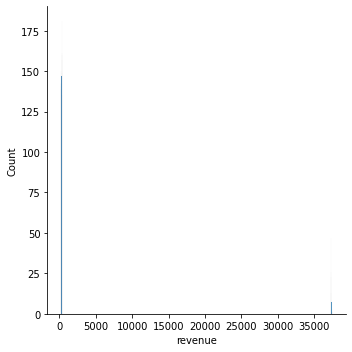

In [136]:
sns.displot(dataAB.query('testgroup == "a" and revenue > 0'), x = 'revenue')

Большая часть наблюдений сосредоточена в левой части графика. Из общей картины выбираются пара наблюдений в правой части, наблюдения с чеком более 30000. Чтобы график был информативнее построим распределение без их учета:

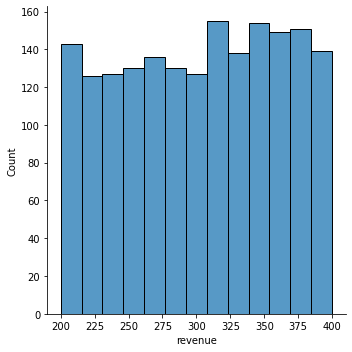

In [137]:
sns.displot(dataAB.query('testgroup == "a" and revenue > 0 and revenue < 30000'), x = 'revenue')

Построим распределение для тестовой группы:

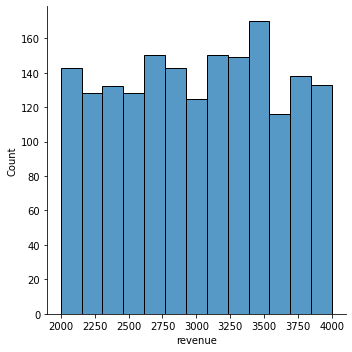

In [138]:
sns.displot(dataAB.query('testgroup == "b" and revenue > 0'), x = 'revenue')

Наши распределения на нормальные не похожи, убедимся в этом при помощи теста Шапиро-Уилка:

Проведем тест для группы A. \
H0: выборка распределена нормальным образом \
H1: распределение ненормальное

In [139]:
stat, p = shapiro(dataAB.query('testgroup == "a" and revenue > 0').revenue)

In [140]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0.')
else:
    print('Не отклоняем H0.')

Отклоняем H0.


Проведем тест для группы B. \
H0: выборка распределена нормальным образом \
H1: распределение ненормальное

In [141]:
stat, p = shapiro(dataAB.query('testgroup == "b" and revenue > 0').revenue)

In [142]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0.')
else:
    print('Не отклоняем H0.')

Отклоняем H0.


Мы убедились, что данные распределены не нормально. В достаточно больших выборках t-критерий неплохо справляется с ненормальным распределением. Намного опаснее для t-теста наличие выбросов. Примем на веру, что в нашем датасете выбросов нет и будем считать что высокий чек в группе A не случайность. \
Применим тест Стьюдента для сравнения средних значений двух групп:

H0: различия между средними значениями нет \
H1: средние в группах значимо различаются

In [143]:
stat, p = stats.ttest_ind (a = dataAB.query('testgroup == "a" and revenue > 0').revenue, \
                b = dataAB.query('testgroup == "b" and revenue > 0').revenue)

In [144]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0.')
else:
    print('Не отклоняем H0.')

Не отклоняем H0.


Выявить статистически значимых различий не получилось.

#### Далее рассмотрим показатель ARPU.

ARPU для группы A:

In [145]:
dataAB.query('testgroup == "a"').revenue.sum() / dataAB.query('testgroup == "a"').user_id.nunique()

25.413719736965806

ARPU для группы B:

In [146]:
dataAB.query('testgroup == "b"').revenue.sum() / dataAB.query('testgroup == "b"').user_id.nunique()

26.75128659327863

Видим, что значение в тестовой группе лучше, чем в контрольной. Проверим, значимы ли эти различия.

Посмотрим на график распределения столбца revenue для всех пользователей. Начнем с контрольной группы A:

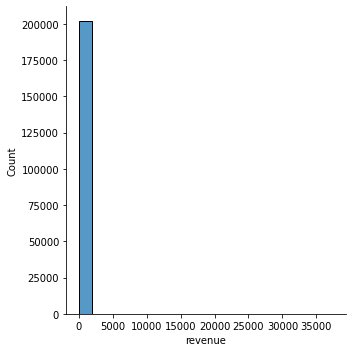

In [147]:
sns.displot(dataAB.query('testgroup == "a"'), x = 'revenue')

Построим распределение для тестовой группы:

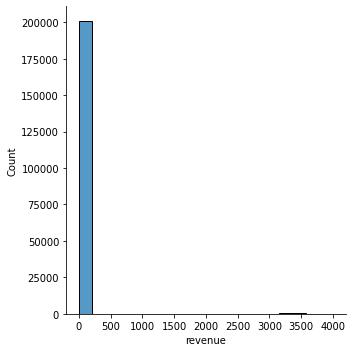

In [148]:
sns.displot(dataAB.query('testgroup == "b"'), x = 'revenue')

Распределения на нормальные не похожи. Также как и на предыдущем шагу проверим данные на нормальность с помощью теста Шапиро-Уилка:

In [149]:
shapiro(dataAB.query('testgroup == "a"').revenue)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

Видим предупреждение, что при объеме выборки более 5000 значение p может быть неточным. В таком случае мы можем рассмотреть тест Андерсона-Дарлинга.

Проведем тест для группы A. \
H0: данные распределены нормальным образом \
H1: распределение ненормальное

In [150]:
stats.anderson(dataAB.query('testgroup == "a"').revenue)

AndersonResult(statistic=77221.00043053087, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Статистика теста равна 77221.00043053087. Сравним это значение с критическим значением, соответствующим уровню значимости 0.05, чтобы увидеть, значимы ли результаты теста. Для уровня значимости 0.05 критическим значением является 0.787. 77221.00043053087 >> 0.787. \
Мы видим, что результаты теста являются значимыми, а это означает, что мы отвергаем нулевую гипотезу теста. Таким образом, данные выборки распределены ненормально.

Аналогично проведем тест для группы B. \
H0: данные распределены нормальным образом \
H1: распределение ненормальное

In [151]:
stats.anderson(dataAB.query('testgroup == "b"').revenue)

AndersonResult(statistic=77383.39298710425, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Для уровня значимости 0.05 критическим значением является 0.787. 77383.39298710425 >> 0.787.\
Отвергаем нулевую гипотезу теста, данные выборки распределены ненормально.

Применим тест Стьюдента для сравнения средних значений двух групп:

H0: различия между средними значениями нет \
H1: средние в группах значимо различаются

In [152]:
stat, p = stats.ttest_ind (a = dataAB.query('testgroup == "a"').revenue, \
                b = dataAB.query('testgroup == "b"').revenue)

In [153]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0.')
else:
    print('Не отклоняем H0.')

Не отклоняем H0.


Выявить статистически значимых различий не получилось.

#### Доля платящих пользователей.

Доля платящих пользователей для группы A:

In [154]:
dataAB.query('testgroup == "a" and revenue > 0').user_id.nunique() \
    / dataAB.query('testgroup == "a"').user_id.nunique()

0.009539690157988749

Доля платящих пользователей для группы B:

In [155]:
dataAB.query('testgroup == "b" and revenue > 0').user_id.nunique() \
    / dataAB.query('testgroup == "b"').user_id.nunique()

0.008906235351586593

Видим, что значение в конктрольной группе лучше, чем в тестовой. Проверим, значимы ли эти различия.

In [156]:
dataAB['is_purchase'] = dataAB['revenue'].apply(lambda x: 'purchase' if x > 0 else 'without_purchase')
dataAB.head()

,user_id,revenue,testgroup,is_purchase
0,1,0,b,without_purchase
1,2,0,a,without_purchase
2,3,0,a,without_purchase
3,4,0,b,without_purchase
4,5,0,b,without_purchase


Так как есть две категориальные переменные, используем тест хи-квадрат. Сформулируем гипотезы, которые будем тестировать: \
𝐻0 : взаимосвязи между переменными нет \
𝐻1 : взаимосвязь есть

Для того чтобы применить критерий Пирсона построим таблицу сопряженности:

In [157]:
sopr_table = pd.pivot(dataAB.groupby(['testgroup', 'is_purchase'], as_index = False).agg({'user_id':'count'}), \
         index = 'testgroup', columns = 'is_purchase')
sopr_table

user_id                 
is_purchase purchase without_purchase
testgroup                            
a               1928           200175
b               1805           200862

Применим критерий Пирсона:

In [158]:
stat, p, dof, expected = chi2_contingency(sopr_table)
print('Statistic = ', stat)
print('p-value = ', p)

Statistic =  4.374729521260405
p-value =  0.03647561892312613


По резулятатам теста

In [159]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0.')
else:
    print('Не отклоняем H0.')

Отклоняем H0.


Если бы нулевая гипотеза была верна, то таблица с ожидаемыми значениями:

In [160]:
pd.DataFrame(expected)

,0,1
0,1863.899249,200239.100751
1,1869.100751,200797.899249


Проведя тест, можем сделать вывод, что взаимосвязь есть, новый алгоритм повлиял на качество сервиса. Но показатель стал хуже для тестовой группы, чем для контрольной.

#### Таким образом, метрики ARPU и ARPPU не изменились, показатель доли платящих пользователей ухудшился, поэтому лучше не вводить в работу новый набор акций.

## Задание 3 

#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? 

Можно посчитать абсолютную конверсию, чтобы увидеть, какой процент пользователей прошел от первого уровня до последнего (или до любого другого, в том числе процент тех, кто начал участвовать в событии, т.е. перешел на 1 уровень) и сравнить с предыдущими тематическими событиями. Это поможет понять, интересно ли пользователям данное событие. \
Также мы можем найти относительную конверсию между каждым уровнем, чтобы посмотреть, нет ли слишком сложного уровня, на котором отваливается большинство пользователей. \
В том числе можно посчитать DAU для периода проведения события и некоторого времени до для того чтобы видеть, увеличилось ли количество уникальных пользователей после его начала. Можно сравнить MAU разных месяцев.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

В этом случае мы также можем посчитать и относительную конверсию, и абсолютную, а также также DAU и MAU. Нам не менее, а даже более важно, с каким из уровней возникает больше сложностей, чем было ожидаемо и как событие влияет на колчичесвто уникальных пользователей. \
Есть смысл рассмотреть retention rate для того чтобы понимать, сколько игроков возвращаются в игру после неудачной попытки выполнения уровня. При усложнении механики особенно важно следить за количеством отвалившимихя пользователей (churn rate) и уровнями, на которых их отвалилось больше всего.